In [1]:
!hostname

interactive2


In [3]:
infile = open('/hpc/users/neffr01/jason_new/hapcut_outputs/hg002_re_000000F/ipds/hg002_ipds_priors_merged_000000F.sort.tsv', 'rb')
outfile = open('/hpc/users/neffr01/jason_new/hapcut_outputs/hg002_re_000000F/ipds/hg002_ipds_priors_merged_000000F.sort.dedup.tsv', 'wb')
lastmotif = None
outdata = ''
for line in infile:
    motif,data = line.strip('\n').split('\t')
    if lastmotif == motif:
        outdata += ',' + data
    else:
        if lastmotif != None:
            outfile.write(lastmotif + '\t' + outdata + '\n')
        outdata = data
    lastmotif = motif

In [5]:
outfile.close()
infile.close()

In [6]:
%run ipy_setup.py
%matplotlib inline
import sklearn
import pysam
import math
from IPython import display
from sklearn.neighbors import KernelDensity
from scipy.stats import gaussian_kde
from statsmodels.nonparametric.kde import KDEUnivariate
from statsmodels.nonparametric.kernel_density import KDEMultivariate


def kde_scipy(x, x_grid, bandwidth=0.2, **kwargs):
    """Kernel Density Estimation with Scipy"""
    # Note that scipy weights its bandwidth by the covariance of the
    # input data.  To make the results comparable to the other methods,
    # we divide the bandwidth by the sample standard deviation here.
    kde = gaussian_kde(x, bw_method=bandwidth / x.std(ddof=1), **kwargs)
    return kde.evaluate(x_grid)

pd.set_option('display.width', 900)
pd.set_option('display.max_columns', 100)
plt.style.use('ggplot')
rcParams['figure.figsize'] = (12, 8)
rcParams['figure.dpi'] = 150
rcParams['font.size'] = 16
rcParams['font.family'] = 'Bitstream Vera Sans'

read_bpos = dict()

def get_refmap(bamread):
    bpos = bamread.get_aligned_pairs(matches_only=True)
    positions = [i[0] for i in bpos]
    refpos =  [i[1] for i in bpos] # positions in reference
    refmap = dict(zip(refpos, positions))
    return refmap

def get_matched_bases_in_read(bamread, in_pos, refmap, read_bpos=read_bpos):
    outseq = [bamread.seq[refmap[i]] if i in refmap else 'N' for i in in_pos]
    outseq = ''.join(outseq)
    return outseq

def get_position_in_read(bamread, in_pos, refmap, read_bpos=read_bpos):
    outpos = None
    if in_pos in refmap:
        outpos = refmap[in_pos]
    return outpos

def reverse_compl(seq):
    translate = {'A':'T', 
                 'T':'A', 
                 'C':'G',
                 'G':'C', 
                 'N':'N'}
    return ''.join([translate[s] for s in seq])

In [2]:
basedir = '/sc/orga/scratch/bashia02/collaborations/hardik_shah/jason_new/hapcut_outputs/hg002_re_000000F/'
bam_fp = pysam.Samfile(basedir + 'hg002_000000F.new.merged.bam', 'rb')

sequences = dict( (s.name, s) for s in ht.FastaReader("/hpc/users/neffr01/jason_new/contig_000000F.fa") )

In [158]:
# get methylation by column (SLOW)
read_parsed_ipds_test = dict()
motif_ipd_values_test = dict()

pbar = ProgressBar(33500000)
motif_len = 11
mhl = int(math.floor(motif_len/2))
count = 0
for i in bam_fp.pileup():
    pbar.animate()
    count += 1
    if count > 1000:
        break
    ref_pos = i.reference_pos
    if ref_pos < mhl+1: continue # motif runs over start of ref
    ref_motif = str(sequences['000000F'][ref_pos-mhl:ref_pos+mhl+1]) # this is an 11-mer
    ref_3mer = ref_motif[mhl-1:mhl+2]
    for read in i.pileups:
        qpos = read.query_position
        if (qpos <= mhl)|(qpos >= read.alignment.query_length - mhl) :
            continue # cannot determine full motif
        read_3mer = get_matched_bases_in_read(read.alignment, range(ref_pos-1,ref_pos+2), read_bpos)
        if read_3mer != ref_3mer:
            continue
        # okay, if we've gotten this far it means we want to keep the ipd
        if read.alignment.qname not in read_parsed_ipds:
            read_parsed_ipds[read.alignment.qname] = [int(i) for i in read.alignment.get_tag('ip').strip('S').split(',')]
        ipd_val = read_parsed_ipds[read.alignment.qname][qpos]
        if ref_motif in motif_ipd_values:
            motif_ipd_values[ref_motif].append(ipd_val)
        else:
            motif_ipd_values[ref_motif] = [ipd_val]

In [8]:
# get methylation by read (hopefully faster)
basedir = '/sc/orga/scratch/bashia02/collaborations/hardik_shah/jason_new/hapcut_outputs/hg002_re_000000F/'
bam_fp = pysam.Samfile(basedir + 'hg002_000000F.new.merged.bam', 'rb')

ipd_by_position = dict()

pbar = ProgressBar(450000)
count=0
for read in bam_fp.fetch(:
    pbar.animate()
    ipd_values = [int(i) for i in read.get_tag('ip').strip('S').split(',')]
    rstart, rend = read.reference_start, read.reference_end
    rlen = rend-rstart
    refseq = str(sequences['000000F'][rstart:rend])
    refmap = get_refmap(read)
    for refpos in range(rstart+6,rend-6):
        # translate the refpos value to a read-based coord
        basepos = get_position_in_read(read, refpos, refmap)
        if basepos == None: continue
        motif = refseq[refpos-5:refpos+6]
        ref_3mer = motif[4:7]
        read_3mer = get_matched_bases_in_read(read, range(refpos-1,refpos+2), refmap)
        if ref_3mer != read_3mer: continue
        ipd_value = ipd_values[basepos] 
        if refpos in ipd_by_position:
            ipd_by_position[refpos].append(ipd_value)
        else:
            ipd_by_position[refpos] = [ipd_value]
bam_fp.close()

[                  1%                  ]  4647 of 450000 complete Elapsed: 31.3 minutes	 Remaining: 2999.1 minutes

KeyboardInterrupt: 

In [6]:
out_fp = open('/hpc/users/neffr01/2work/methyl_motif_priors/hg002_000000F_ipd-by-position.tsv', 'w')
out_fp.write("#ref_chrom\tref_pos\tipd_at_position\n")
for key in sorted(ipd_by_position.keys()):
    out_fp.write('\t'.join([str(x) for x in ['000000F', key, ','.join([str(a) for a in ipd_by_position[key]])]]) + '\n')
out_fp.close()

In [128]:
import pickle
with open('/hpc/users/neffr01/2work/methyl_motif_priors/hg002_20k_columns.pickle2', 'w') as fp:
    pickle.dump(motif_ipd_values, fp, 2)

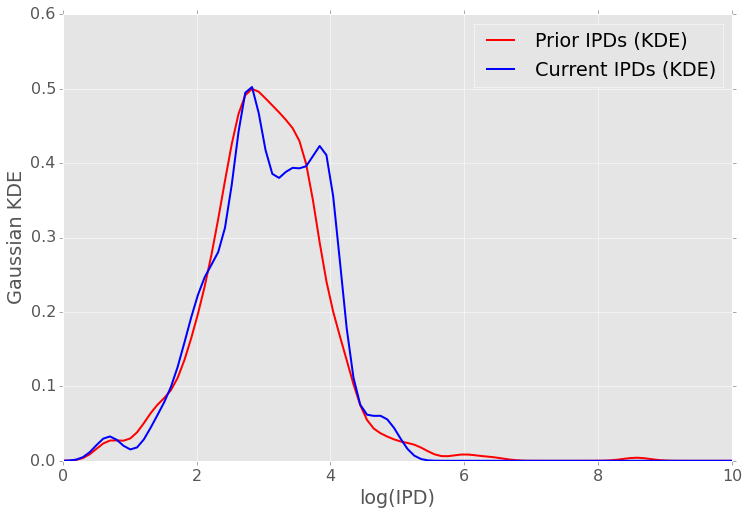

000000F 3889116 motif: GTGTGAAGAGC n_prior: 484 n_curr: 61


KeyboardInterrupt: 

In [64]:
# get methylation by column (slow)
basedir = '/sc/orga/scratch/bashia02/collaborations/hardik_shah/jason_new/hapcut_outputs/hg002_re_000000F/'
bam_fp = pysam.Samfile(basedir + 'hg002_000000F.new.merged.bam', 'rb')
motif_ipd_values = dict()

#pbar = ProgressBar(33500000)
count =0
for i in bam_fp.pileup(reference="000000F", start=3889116, end=3889117):
    #pbar.animate()
    motif_arr = []
    ipds = []
    ref_pos = i.pos
    if ref_pos != 3889116:
        continue # can't determine motif
    motif_arr.append(str(sequences['000000F'][ref_pos-5:ref_pos+6]))
    for read in i.pileups:
        qpos = read.query_position
        if (qpos < 6 )|(qpos > read.alignment.query_length - 6) :
            continue # cannot determine full motif
        read.alignment.get_reference_positions()
        ipds.append(int(read.alignment.get_tag('ip').split(',', qpos+1)[qpos].strip('S')))
    prior_ipds = [int(x) for x in motif_dict[curr_motif].split(',', 2001)[0:2000]]
    if len(prior_ipds) > 1000:
        prior_ipds = prior_ipds[0:1000]
    logx = np.linspace(0,10,100)
    kde_prior = kde_scipy(np.log(prior_ipds), logx)
    kde_curr = kde_scipy(np.log(ipds), logx)
    plt.plot(logx, kde_prior, 'r-', label="Prior IPDs (KDE)")
    plt.plot(logx, kde_curr, 'b-', label="Current IPDs (KDE)")
    #plt.hist(prior_ipds, bins=np.logspace(0.1,3,50),normed=True, color='b', alpha=0.5)
    #plt.hist(ipds, bins=np.logspace(0.1,3,50),normed=True, color='r', alpha=0.5)
    #plt.xscale('log')
    plt.legend()
    plt.xlabel("log(IPD)")
    plt.ylabel("Gaussian KDE")
    plt.show()
    print "000000F", ref_pos, "motif:", motif_arr[0], "n_prior:", len(prior_ipds), "n_curr:", len(ipds)
    sys.stdout.flush()
    wait = raw_input("PRESS ENTER TO CONTINUE.")
    display.clear_output(wait=True)
    display.display(plt.gcf())

In [8]:
pos_in = open('/hpc/users/neffr01/jason_new/hapcut_outputs/hg002_re_000000F/ipds/hg002_ipds_positions_merged_000000F.tsv', 'rb')
motifs_in = open('/hpc/users/neffr01/jason_new/hapcut_outputs/hg002_re_000000F/ipds/hg002_ipds_priors_merged_000000F.sort.dedup.tsv', 'rb')
sequences = dict( (s.name, s) for s in ht.FastaReader("/hpc/users/neffr01/jason_new/contig_000000F.fa") )

motif_dict = dict()

pbar = ProgressBar(3201285)
for line in motifs_in:
    pbar.animate()
    motif,data = line.strip('\n').split('\t')
    motif_dict[motif] = data
    

[*****************99%******************]  3162341 of 3201285 complete Elapsed: 1.8 minutes	 Remaining: 0.0 minutes


In [161]:
import cProfile
import re
cProfile.run('test_it(bam_fp)', sort=2)

[                  0%                  ]  865 of 33500000 complete Elapsed: 0.2 minutes	 Remaining: 7803.9 minutes          1601498 function calls in 14.332 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000   14.332   14.332 <string>:1(<module>)
        1    0.593    0.593   14.332   14.332 <ipython-input-158-151942e19214>:1(test_it)
      994    0.080    0.000   10.713    0.011 calignmentfile.pyx:3734(__get__)
    77539    0.108    0.000   10.634    0.000 calignmentfile.pyx:146(makePileupRead)
    77539   10.525    0.000   10.525    0.000 calignmentfile.pyx:127(makeAlignedSegment)
    74816    0.437    0.000    2.253    0.000 <ipython-input-159-69237dc8ab36>:30(get_matched_bases_in_read)
    74816    0.295    0.000    1.444    0.000 <ipython-input-159-69237dc8ab36>:49(get_seq)
    37171    0.036    0.000    1.149    0.000 calignmentfile.pyx:3602(__get__)
    37171    0.031    0.000    1.113    0

In [52]:
opticalmap = pd.read_csv('/hpc/users/neffr01/2work/alex_na24385_phasing/hmap_combine/alex_merged_hapinform_000000F.txt', sep=' ', 
                         header=None)
opticalmap.sort(columns=5, inplace=True)

In [101]:
opticalset = set({3366531,  3889116,  4207133,  4425218,  4487852,  
4702639,  5045343,  5583143,  5680200,  5768307,  5833916,  6155226,  
6156314,  6570993,  6639583,  6767351,  7068928,  7305328,  7518309,  
7519511,  7602559,  7702805,  7954498,  8165876,  8379084,  8380364,  
8543489,  9099398,  10285036,  10767843,  10822262,  11357859,  11535218,  
11687657,  12308506,  12514736,  12903461,  13030317,  13472377,  
13571579,  13929459,  14271488,  14508482,  14982344,  15416851,  
16528454,  16975566,  17131635,  17131656,  17277992,  17459946,  
17661507,  17894890,  17960782,  18581522,  19136557,  20715234,  
20715942,  20802007,  20842429,  21185532,  21482025,  21611092,  
22128495,  22747901,  22764384,  22807060,  23445922,  24994218,  
26695714,  27981178,  27982485,  28325028,  28925872,  29325841,  
29327157,  29869010,  31716937,  31981142,  32232474,  32643115,  
32652723,  32804199})

In [102]:
list_set = list(opticalset)
for i in list_set:
    for a in range(i-1,i+6):
        opticalset.add(a)

In [33]:
obs = np.concatenate((np.random.randn(100, 1),
...                       10 + np.random.randn(300, 1)))

In [108]:
from scipy import stats

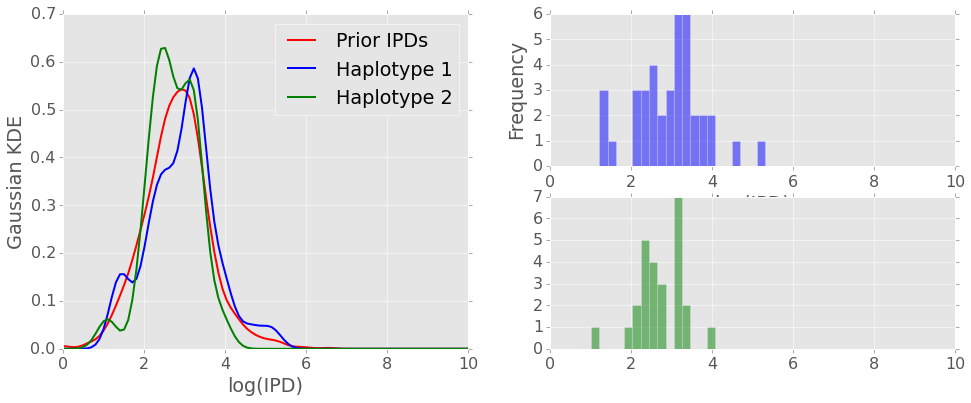

000000F 3366533 motif: GGGCTCTTCCC n_prior: 1083 n_hap1: 39 n_hap2: 26

======mixed======
two components:
	weight  : [ 0.50228689  0.49771311]
	means   : [[ 3.1880187   2.51359096]]
	AIC1:  156.884577128 	BIC1:  167.756513478
one component:
	weight  : [ 1.]
	means   : [[ 2.85234717]]
	AIC:  150.576601952 	BIC:  154.925376492
=====distribution comparisions======
ks test haps  : (0.2435897435897435, 0.27202338530183251)
ks test hap1  : (0.14993962639392006, 0.33911911403221673)
ks test hap2  : (0.13236025285886788, 0.73485437385654873)


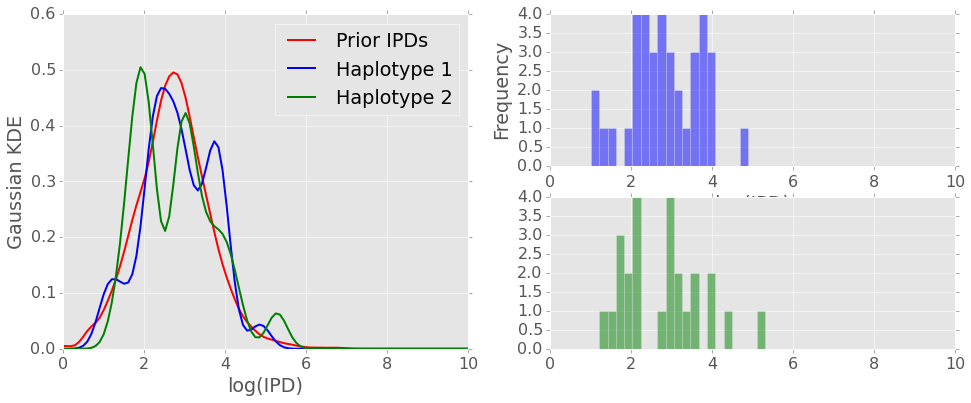

000000F 3366534 motif: GGCTCTTCCCC n_prior: 1181 n_hap1: 37 n_hap2: 25

======mixed======
two components:
	weight  : [ 0.50037365  0.49962635]
	means   : [[ 2.29936428  3.34357788]]
	AIC1:  171.626486426 	BIC1:  182.262158351
one component:
	weight  : [ 1.]
	means   : [[ 2.82108091]]
	AIC:  167.043431406 	BIC:  171.297700176
=====distribution comparisions======
ks test haps  : (0.19783783783783782, 0.55469641876573128)
ks test hap1  : (0.14149712794928715, 0.43972269143118636)
ks test hap2  : (0.16057578323454702, 0.5161852138120937)


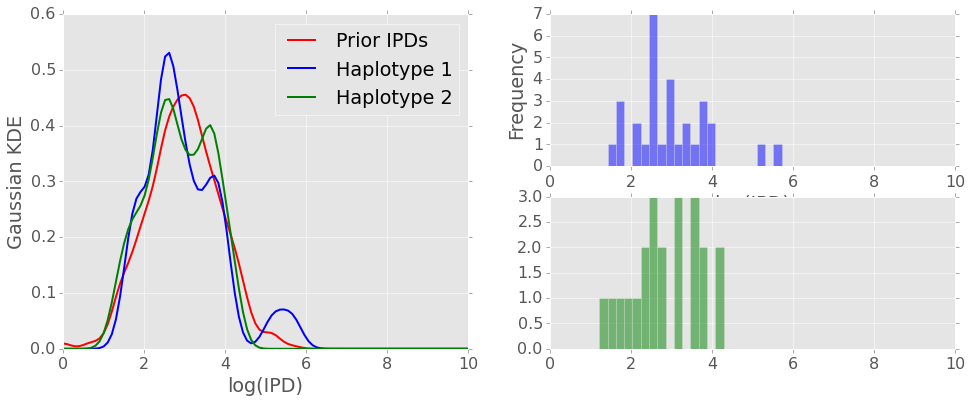

000000F 3366535 motif: GCTCTTCCCCC n_prior: 416 n_hap1: 30 n_hap2: 22

======mixed======
two components:
	weight  : [ 0.57166159  0.42833841]
	means   : [[ 2.52681846  3.47610359]]
	AIC1:  141.470177526 	BIC1:  151.226396119
one component:
	weight  : [ 1.]
	means   : [[ 2.93343374]]
	AIC:  138.05091192 	BIC:  141.953399357
=====distribution comparisions======
ks test haps  : (0.096969696969696928, 0.99948628147568641)
ks test hap1  : (0.10368589743589746, 0.90908591393021143)
ks test hap2  : (0.10074300699300698, 0.97772134453596082)


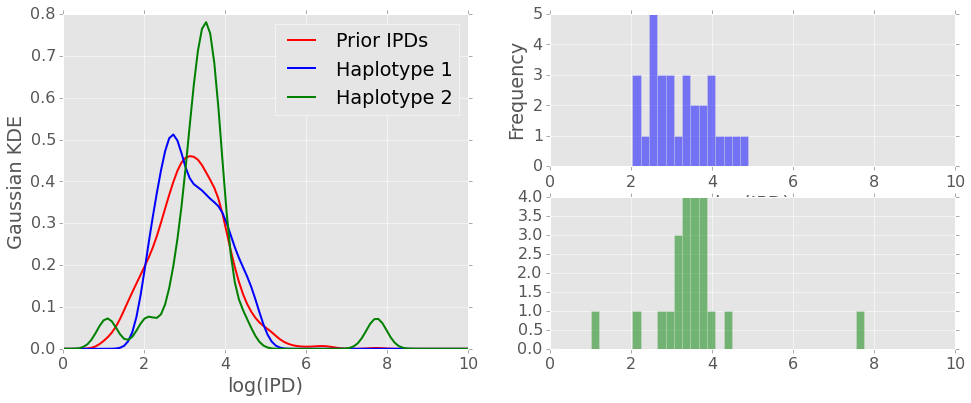

000000F 3366536 motif: CTCTTCCCCCT n_prior: 1057 n_hap1: 30 n_hap2: 22

======mixed======
two components:
	weight  : [ 0.07507654  0.92492346]
	means   : [[ 4.10485049  3.28378512]]
	AIC1:  133.966524178 	BIC1:  143.72274277
one component:
	weight  : [ 1.]
	means   : [[ 3.34542787]]
	AIC:  144.911689575 	BIC:  148.814177012
=====distribution comparisions======
ks test haps  : (0.31818181818181818, 0.12254295041198505)
ks test hap1  : (0.098391674550614955, 0.92752117200554407)
ks test hap2  : (0.27513546056592414, 0.062357746846069428)


In [120]:
import itertools
'''
# Three subplots sharing both x/y axes
f, (ax1, ax2, ax3) = plt.subplots(3, sharex=True, sharey=True)
ax1.plot(x, y)
ax1.set_title('Sharing both axes')
ax2.scatter(x, y)
ax3.scatter(x, 2 * y ** 2 - 1, color='r')
# Fine-tune figure; make subplots close to each other and hide x ticks for
# all but bottom plot.
f.subplots_adjust(hspace=0)
plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)
'''
import matplotlib.gridspec as gridspec
pd.set_option('display.width', 900)
pd.set_option('display.max_columns', 100)
plt.style.use('ggplot')
rcParams['figure.figsize'] = (16, 6)
rcParams['figure.dpi'] = 150
rcParams['font.size'] = 16
rcParams['font.family'] = 'Bitstream Vera Sans'

pos_in = open('/hpc/users/neffr01/jason_new/hapcut_outputs/hg002_re_000000F/hapcut_qv13_mq10/test_ipd_positions_000000F:3366500-3366600.tsv', 'rb')
for line in pos_in:
    if line[0] == "#":
        continue
    chrom, pos, ipdl_hap1, ipdl_hap2 = line.strip('\n').split('\t')
    pos = int(pos)
    #if pos < 2000: 
    #    continue
    if pos not in opticalset:
        continue 
    curr_motif = str(sequences['000000F'][pos-5:pos+6])
    prior_ipds = [int(x) for x in motif_dict[curr_motif].split(',', 2001)[0:2000]]
    if (ipdl_hap1 == '')|(ipdl_hap2 == ''):
        continue
    ipd_hap1 = [int(x) for x in ipdl_hap1.split(',')]
    ipd_hap2 = [int(x) for x in ipdl_hap2.split(',')]
    if (len(ipd_hap1) < 3) | (len(ipd_hap2) < 3):
        continue
    kstest_haps = stats.ks_2samp(ipd_hap1, ipd_hap2)
    kstest_prior1 = stats.ks_2samp(prior_ipds, ipd_hap1)
    kstest_prior2 = stats.ks_2samp(prior_ipds, ipd_hap2)
    #if kstest_haps[1] > 0.05:
    #    continue
    #if min([kstest_prior1[1], kstest_prior2[1]]) > 0.05:
    #    continue
    logx = np.linspace(0,10,100)
    halflogx = np.linspace(0,10,50)
    kde_prior = kde_scipy(np.log(prior_ipds), logx)
    kde_hap1 = kde_scipy(np.log(ipd_hap1), logx, bandwidth=0.25)
    kde_hap2 = kde_scipy(np.log(ipd_hap2), logx, bandwidth=0.25)
    gs = gridspec.GridSpec(2, 2)
    ax1 = plt.subplot(gs[:,0])
    ax2 = plt.subplot(gs[0,1])
    ax3 = plt.subplot(gs[1,1])
    ax1.plot(logx, kde_prior, 'r-', label="Prior IPDs")
    ax1.plot(logx, kde_hap1, 'b-', label="Haplotype 1")
    ax1.plot(logx, kde_hap2, 'g-', label="Haplotype 2")
    #plt.hist(prior_ipds, bins=np.logspace(0.1,3,50),normed=True, color='b', alpha=0.5)
    #plt.hist(ipds, bins=np.logspace(0.1,3,50),normed=True, color='r', alpha=0.5)
    #plt.xscale('log')
    ax1.legend()
    ax1.set_xlabel("log(IPD)")
    ax1.set_ylabel("Gaussian KDE")
    #plt.show()
    obs1 = np.array([[np.log(i)] for i in ipd_hap1])
    obs2 = np.array([[np.log(i)] for i in ipd_hap2])
    obs = np.concatenate((obs1, obs2))
    ax2.hist(obs1, bins=halflogx, color='b', alpha=0.5)
    ax3.hist(obs2, bins=halflogx, color='g', alpha=0.5)
    ax2.set_xlabel("log(IPD)")
    ax2.set_ylabel("Frequency")
    f.subplots_adjust(hspace=0)
    plt.setp([a.get_xticklabels() for a in f.axes[:-1]], visible=False)
    plt.show()
    print "000000F", pos, "motif:", curr_motif, "n_prior:", len(prior_ipds), "n_hap1:", len(ipd_hap1), "n_hap2:", len(ipd_hap2)
    print ""
    print "======mixed======"
    print "two components:"
    g = mixture.GMM(n_components=2)
    x = g.fit(obs)
    print "\tweight  :", x.weights_
    print "\tmeans   :", np.reshape(x.means_, (1,2))
    print '\tAIC1: ', x.aic(obs), '\tBIC1: ', x.bic(obs)
    print "one component:"
    g = mixture.GMM(n_components=1)
    #obs = np.array([[np.log(i)] for i in ipds])
    x = g.fit(obs)
    print "\tweight  :", x.weights_
    print "\tmeans   :", x.means_
    print '\tAIC: ', x.aic(obs), '\tBIC: ', x.bic(obs)
    
    print "=====distribution comparisions======"
    print "ks test haps  :", kstest_haps
    print "ks test hap1  :", kstest_prior1
    print "ks test hap2  :", kstest_prior2
    sys.stdout.flush()
    #wait = raw_input("PRESS ENTER TO CONTINUE.")
    #display.clear_output(wait=True)
    #display.display(plt.gcf())
    